In [2]:
%load_ext autoreload
%autoreload 2

# autograd calc for single ssh chain

In [3]:
import torch
import scipy.io as sio
from hamiltonians.Central import SSHChain, SSHChainBdG
from hamiltonians.Lead import SpinlessLead
from greens_functions.construct_ginv_total import construct_ginv_total
from calculations.calculation_cf_autograd import calculation_cf_autograd
funcDevice='cuda'
# Define parameters for the central region
Ny = 1  # Number of lattice sites in the y-direction
Nx_cell = 2
Nx = 2* Nx_cell
t_u = torch.tensor(-1.0, dtype=torch.complex64, device=funcDevice) #inter-cell hopping
t_v = torch.tensor(-0.5, dtype=torch.complex64, device=funcDevice) #intra-cell hopping
mu = torch.tensor(-1.0, dtype=torch.complex64, device=funcDevice)
Delta = torch.tensor(0.0, dtype=torch.complex64, device=funcDevice)
splitting_onsite_energy = torch.tensor(0.0, dtype=torch.complex64, device=funcDevice)

# Create SSH chain Hamiltonian
ssh_chain_bdg = SSHChainBdG(Nx_cell, t_u, t_v, mu, Delta, splitting_onsite_energy)
ssh_chain = SSHChain(Nx_cell, t_u, t_v, mu, splitting_onsite_energy)
# Get the Hamiltonian matrix
H_BdG = ssh_chain_bdg.H_full_BdG
H_normal = ssh_chain.H_full
Eigenvalues_normal = torch.linalg.eigvals(H_normal).real
print(Eigenvalues_normal)

tensor([ 2.2071, -0.2071,  1.2071,  0.7929], device='cuda:0')


In [4]:
# Calculate eigenvalues of the SSH chain Hamiltonian
eigenvalues = torch.linalg.eigvals(H_BdG).real

# Sort eigenvalues for better visualization
sorted_eigenvalues = eigenvalues.sort()[0]

# Print the sorted eigenvalues
print("Sorted eigenvalues of the SSH chain Hamiltonian:")
print(sorted_eigenvalues)


Sorted eigenvalues of the SSH chain Hamiltonian:
tensor([-2.2071, -1.2071, -0.7929, -0.2071,  0.2071,  0.7929,  1.2071,  2.2071],
       device='cuda:0')


In [5]:
# Define parameters for the leads as torch tensors
mu_values = torch.tensor([-20.0, 20.0], dtype=torch.float32, device=funcDevice)
t_lead_central = torch.tensor(1, dtype=torch.float32, device=funcDevice)
t_lead = torch.tensor(20.0, dtype=torch.float32, device=funcDevice)
temperature = torch.tensor(1e-6, dtype=torch.float32, device=funcDevice)

# Create connection coordinates for the leads
# Left lead connects to the left edge of the central region
left_connections = [(0, y) for y in range(Ny)]
# Right lead connects to the right edge of the central region
right_connections = [(Nx-1, y) for y in range(Ny)]

# Create lead objects using the proper Lead class parameters
leads_info = [
    SpinlessLead(
        mu=mu_values[0], 
        t_lead=t_lead, 
        t_lead_central=t_lead_central, 
        temperature=temperature,
        connection_coordinates=left_connections,
        central_Nx=Nx,
        central_Ny=Ny,
        device=funcDevice
    ),
    SpinlessLead(
        mu=mu_values[1], 
        t_lead=t_lead, 
        t_lead_central=t_lead_central, 
        temperature=temperature,
        connection_coordinates=right_connections,
        central_Nx=Nx,
        central_Ny=Ny,
        device=funcDevice
    )
]

# Define energy and small imaginary part for regularization
# Calculate eigenvalues of H_BdG
eigenvalues = torch.linalg.eigvals(H_BdG).real.sort()[0]  # Sort eigenvalues

# Create base energy grid
E_min, E_max = -1, 3
num_points = 4000
base_E = torch.linspace(E_min, E_max, steps=num_points, dtype=torch.float32, device=funcDevice)

E = base_E

eta = torch.tensor(1e-8, dtype=torch.float32, device=funcDevice)  # Small imaginary part for regularization on CUDA

# Create directory to save results with parameter information
import os
import time
from datetime import datetime

params_str = f"Ny{Ny}_Nx{Nx}_mu{mu_values[0]:.1f}_{mu_values[1]:.1f}_t{t_lead:.1f}_E{E_min:.2f}_{E_max:.2f}_pts{num_points}"
results_dir = os.path.join("data", "ssh_chain", "compareGenwithDirect", f"results_{datetime.now().strftime('%Y%m%d_%H%M')}_{params_str}")
os.makedirs(results_dir, exist_ok=True)

# Method 1: Using autograd general function method
chunk_size = 50  # Define the chunk size
results_list_autograd = []

start_time_autograd = time.time()
for start in range(0, E.size(0), chunk_size):
    end = min(start + chunk_size, E.size(0))
    chunked_E = E[start:end]
    print(f"Processing chunk {start} to {end}")
    
    # Call the calculation function for the current chunk
    results = calculation_cf_autograd(H_BdG, chunked_E, eta, leads_info, max_derivative_order=2)
    results_list_autograd.append(results)
autograd_time = time.time() - start_time_autograd

# Combine results from all chunks for autograd method
combined_results_autograd = {
    'gen_func_values_real': torch.cat([res['gen_func_values_real'] for res in results_list_autograd], dim=0),
    'gen_func_values_imag': torch.cat([res['gen_func_values_imag'] for res in results_list_autograd], dim=0),
    'derivatives': {}
}

# Combine derivatives
for order in results_list_autograd[0]['derivatives'].keys():
    combined_results_autograd['derivatives'][order] = torch.cat([res['derivatives'][order] for res in results_list_autograd], dim=0)
# Convert autograd results to numpy as well
combined_results_autograd = {
    'gen_func_values_real': combined_results_autograd['gen_func_values_real'].cpu().numpy(),
    'gen_func_values_imag': combined_results_autograd['gen_func_values_imag'].cpu().numpy(),
    'derivatives': {
        order: tensor.cpu().numpy() 
        for order, tensor in combined_results_autograd['derivatives'].items()
    }
}

# Method 2: Using direct calculation method from greens_functions/direct_calculation.py
from greens_functions.direct_calculation import calculate_transport_properties

results_list_direct = []
start_time_direct = time.time()
for start in range(0, E.size(0), chunk_size):
    end = min(start + chunk_size, E.size(0))
    chunked_E = E[start:end]
    print(f"Processing chunk {start} to {end}")
    # Call the direct calculation function for the current chunk
    results = calculate_transport_properties(
        E_batch=chunked_E,
        H_total=H_BdG,
        leads_info=leads_info,
        temperature=temperature,
        eta=eta
    )
    results_list_direct.append(results)
direct_time = time.time() - start_time_direct

# Combine results from all chunks for direct calculation method
combined_results_direct = {}
for key in results_list_direct[0].keys():
    if isinstance(results_list_direct[0][key], torch.Tensor):
        combined_results_direct[key] = torch.cat([res[key] for res in results_list_direct], dim=0).cpu().numpy()
    else:
        # Handle non-tensor data if any
        combined_results_direct[key] = results_list_direct[0][key]



# Save timing information
timing_info = {
    'autograd_time': autograd_time,
    'direct_time': direct_time,
    'speedup_factor': autograd_time / direct_time if direct_time > 0 else float('inf')
}

# Save all results
combined_results_autograd['timing'] = timing_info
combined_results_direct['timing'] = timing_info

# Save results to files
autograd_filename = os.path.join(results_dir, f'autograd_results.mat')
direct_filename = os.path.join(results_dir, f'direct_results.mat')
timing_filename = os.path.join(results_dir, f'timing_comparison.mat')

sio.savemat(autograd_filename, combined_results_autograd)
sio.savemat(direct_filename, combined_results_direct)
sio.savemat(timing_filename, timing_info)

# Print timing comparison
print(f"\nPerformance Comparison:")
print(f"Autograd Generating Function Method: {autograd_time:.4f} seconds")
print(f"Direct Calculation Method: {direct_time:.4f} seconds")
print(f"Speedup: {timing_info['speedup_factor']:.2f}x")
print(f"\nResults saved in: {results_dir}")

Processing chunk 0 to 50
Processing chunk 50 to 100
Processing chunk 100 to 150
Processing chunk 150 to 200
Processing chunk 200 to 250
Processing chunk 250 to 300
Processing chunk 300 to 350
Processing chunk 350 to 400
Processing chunk 400 to 450
Processing chunk 450 to 500
Processing chunk 500 to 550
Processing chunk 550 to 600
Processing chunk 600 to 650
Processing chunk 650 to 700
Processing chunk 700 to 750
Processing chunk 750 to 800
Processing chunk 800 to 850
Processing chunk 850 to 900
Processing chunk 900 to 950
Processing chunk 950 to 1000
Processing chunk 1000 to 1050
Processing chunk 1050 to 1100
Processing chunk 1100 to 1150
Processing chunk 1150 to 1200
Processing chunk 1200 to 1250
Processing chunk 1250 to 1300
Processing chunk 1300 to 1350
Processing chunk 1350 to 1400
Processing chunk 1400 to 1450
Processing chunk 1450 to 1500
Processing chunk 1500 to 1550
Processing chunk 1550 to 1600
Processing chunk 1600 to 1650
Processing chunk 1650 to 1700
Processing chunk 1700 t

# compare autograd genfunc to direction Green inverse

Available autograd derivative keys: ['order_1', 'order_2']
Available direct result keys: ['rho_e_jj', 'rho_electron', 'rho_hole', 'transmission', 'andreev', 'current', 'noise', 'timing']


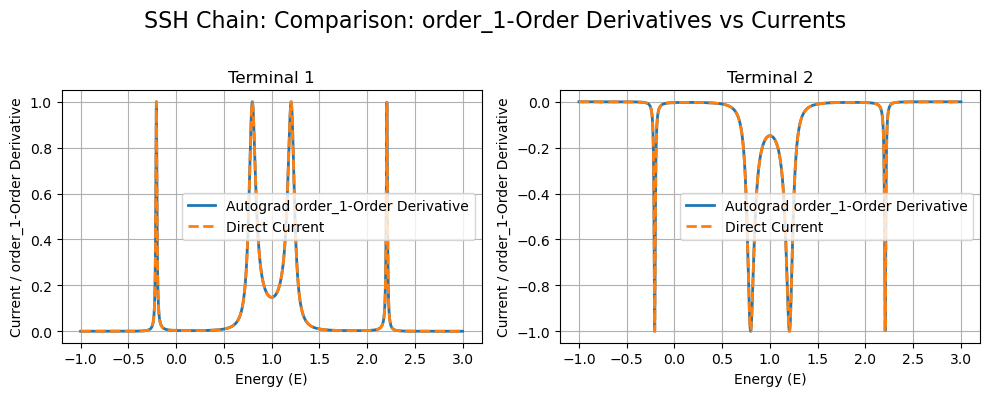

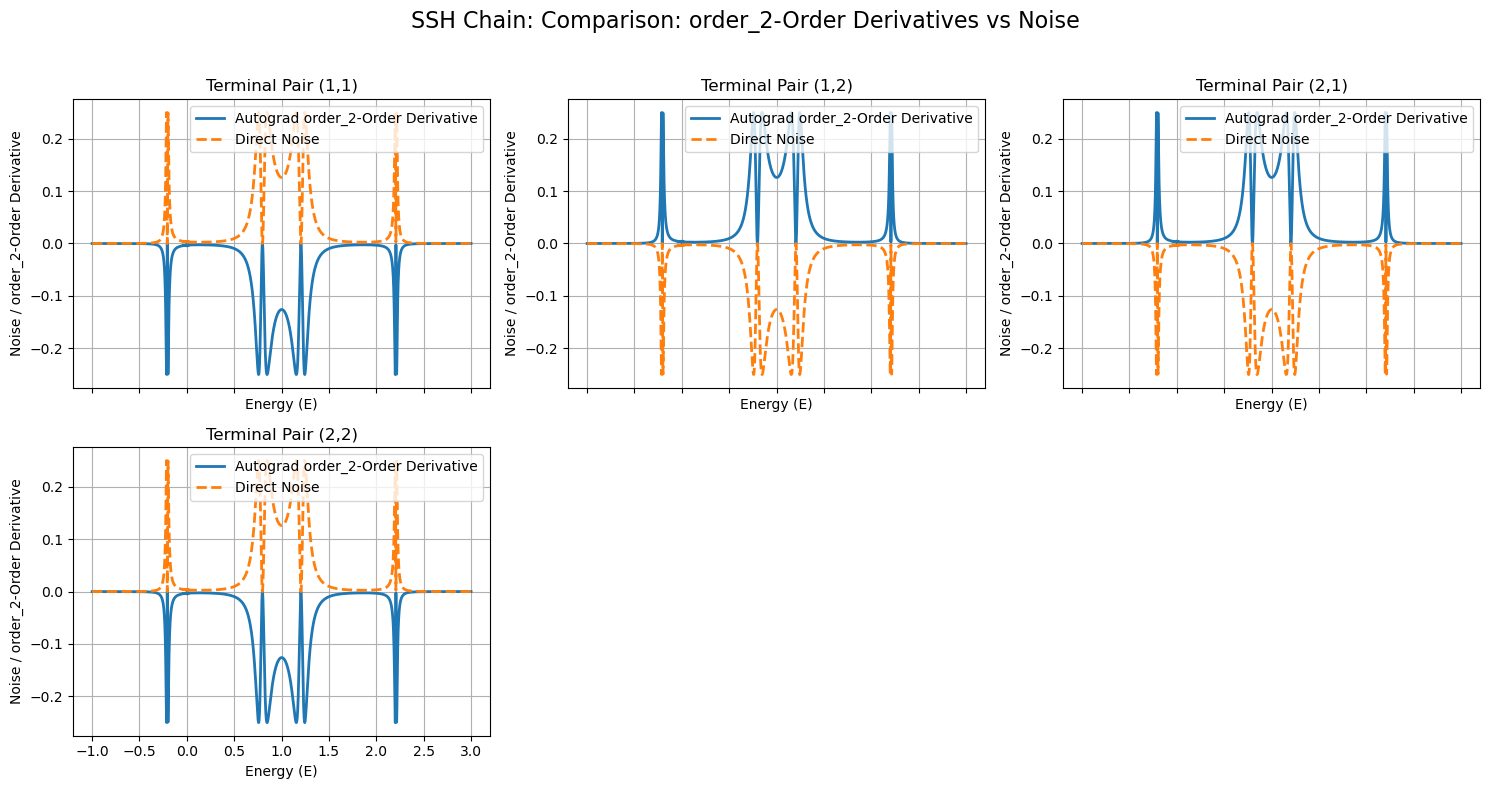

In [6]:
# After running your calculations
from dataplot.transport_plot import plot_comprehensive_comparison

# Create comparison plots
plot_comprehensive_comparison(
    E_values=E,  # Your energy grid
    autograd_results=combined_results_autograd,
    direct_results=combined_results_direct,
    save_dir=os.path.join(results_dir, "comparison_plots"),
    title_prefix="SSH Chain: "
)

In [ ]:
# Plot direct calculation results
from dataplot.transport_plot import plot_all_gradients

plot_all_gradients(
    E_values=E,
    gradient_data=combined_results_autograd,
    save_dir=os.path.join(results_dir, "autograd_calculation_plots"),
    title_prefix="ssh Chain: "
)


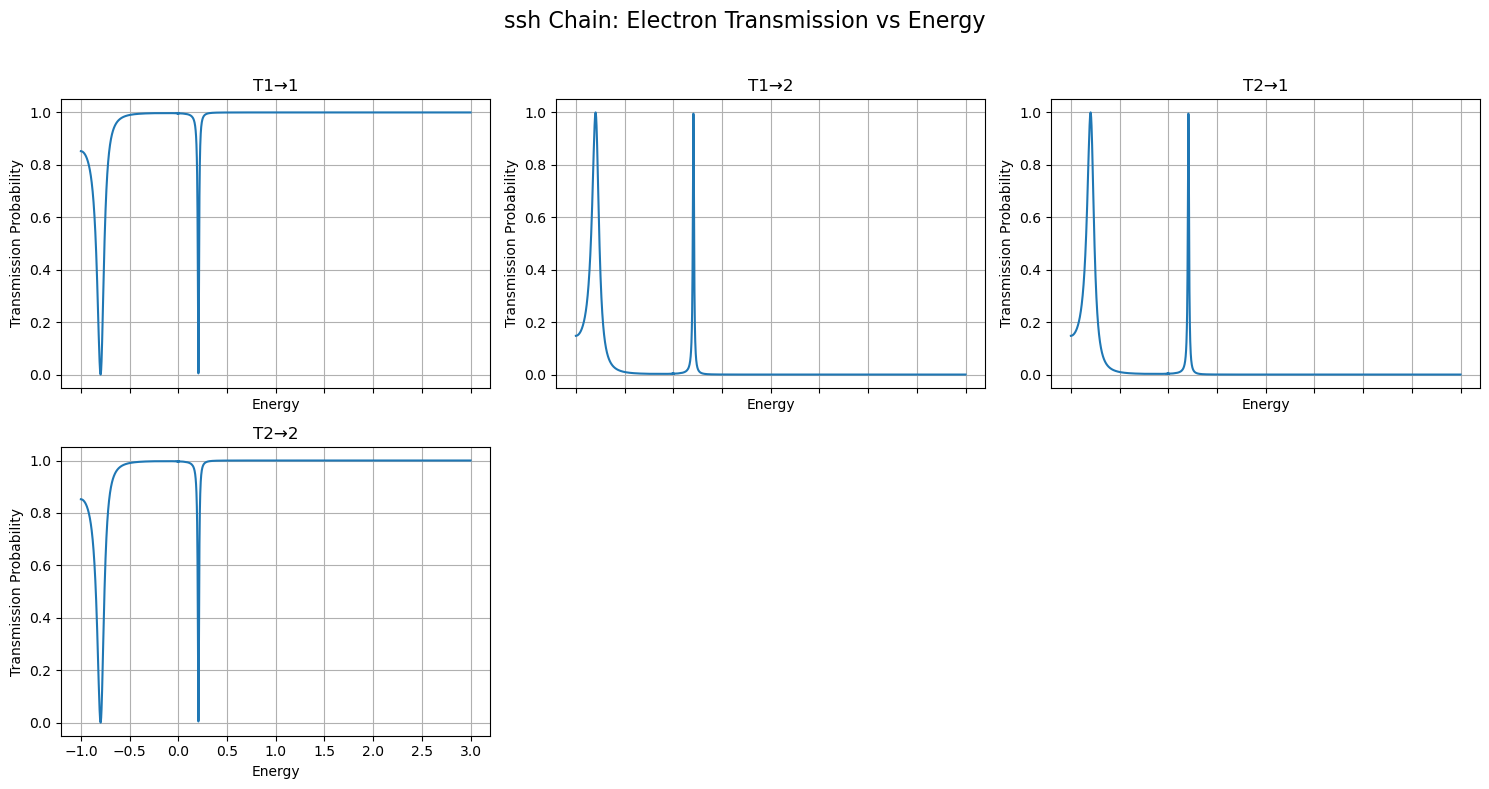

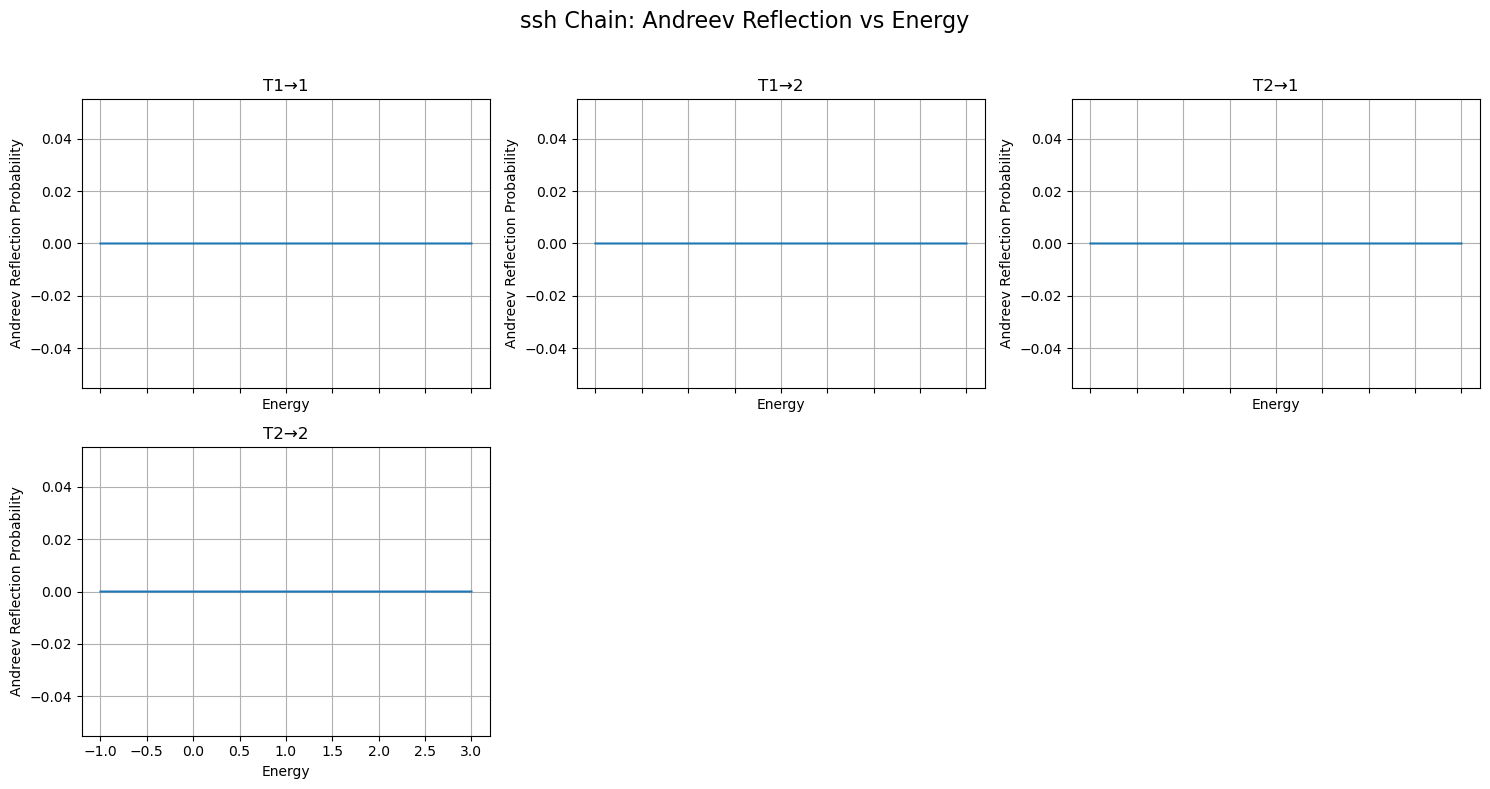

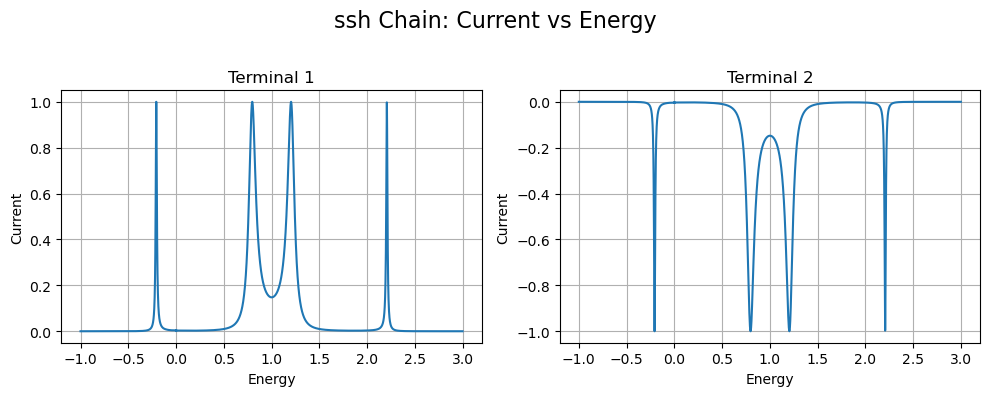

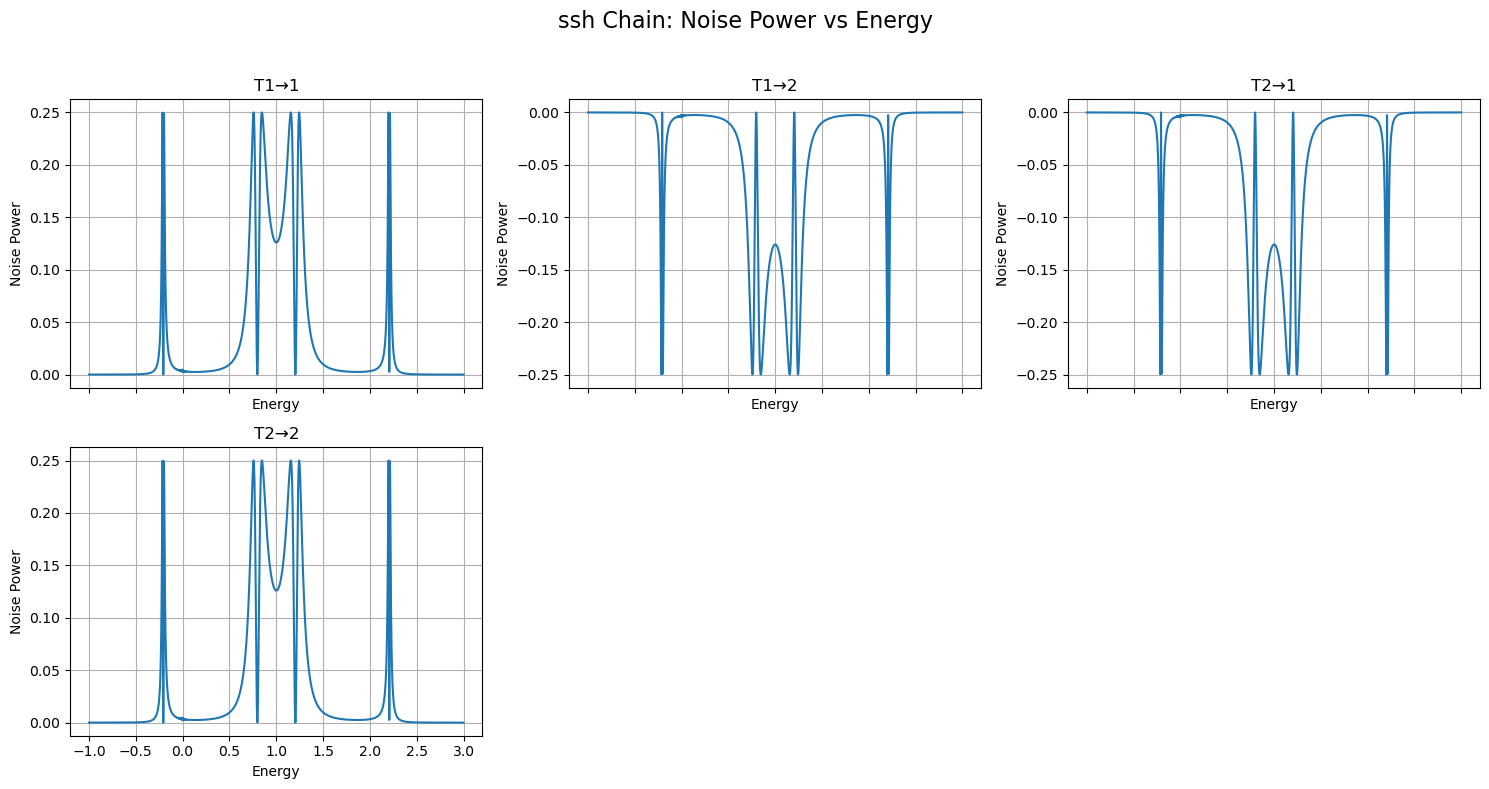

In [6]:
# Plot direct calculation results
from dataplot.transport_plot import plot_all_transport_quantities

plot_all_transport_quantities(
    E_values=E,
    transport_data=combined_results_direct,
    save_dir=os.path.join(results_dir, "direct_calculation_plots"),
    title_prefix="ssh Chain: "
)


# Calc higher order correlations using autograd

In [7]:
# Simple loop code for varying t_lead_central values
import os
import torch
import numpy as np
import scipy.io as sio
from hamiltonians import SSHChainBdG
from hamiltonians.Lead import SpinlessLead
from calculations.calculation_cf_autograd import calculation_cf_autograd
# Define t_lead_central values to loop through
# t_lead_central_values = np.arange(0.1, 1.01, 0.3)  # 0.1, 0.4, 0.7, 1.0
split_onsite_values = np.arange(0.02, 0.101, 0.02)  # 0.2, 0.4, 0.6, 0.8, 1.0
# Loop through t_lead_central values
for split_onsite_value in split_onsite_values:
    print(f"Processing split_onsite_value = {split_onsite_value}")
    # Define SSH chain parameters
    Nx_cell = 4
    t_u = torch.tensor(-1.0, dtype=torch.complex64)
    t_v = torch.tensor(-0.5, dtype=torch.complex64)
    mu = torch.tensor(-1.0, dtype=torch.complex64)
    Delta = torch.tensor(0.0, dtype=torch.complex64)

    splitting_onsite_energy = torch.tensor(split_onsite_value, dtype=torch.complex64)

    # Create SSH chain Hamiltonian with BdG
    ssh_chain = SSHChainBdG(Nx_cell, t_u, t_v, mu, Delta, splitting_onsite_energy)
    Nx = Nx_cell * 2  # Total number of sites

    # Define energy range and calculation parameters
    E_min, E_max = -1.0, 1.0
    num_points = 3000
    t_lead = torch.tensor(20.0, dtype=torch.float32)
    mu_leads = [-20.0, 20.0]
    temperature = torch.tensor(1e-6, dtype=torch.float32)
    eta = torch.tensor(1e-8, dtype=torch.float32)
    chunk_size = 3

    # Create energy grid
    E = torch.linspace(E_min, E_max, steps=num_points, dtype=torch.float32)




    t_lead_central = torch.tensor(1, dtype=torch.float32)
    
    # Create lead objects
    leads_info = [
        SpinlessLead(mu=torch.tensor(mu, dtype=torch.float32), 
                   t_lead_central=t_lead_central, 
                   temperature=temperature, 
                   Ny=1,  # For 1D chain 
                   t_lead=t_lead)
        for mu in mu_leads
    ]
    
    # Set positions for leads
    leads_info[0].position = torch.tensor([0])
    leads_info[1].position = torch.tensor([Nx-1])
    
    # Process energy values in chunks
    results_list = []
    
    for start in range(0, E.size(0), chunk_size):
        end = min(start + chunk_size, E.size(0))
        chunked_E = E[start:end]
        
        # Call the calculation function for the current chunk
        results = calculation_cf_autograd(ssh_chain.H_full_BdG, chunked_E, eta, leads_info, max_derivative_order=4)
        results_list.append(results)
    
    # Combine results from all chunks
    combined_results = {
        'gen_func_values_real': torch.cat([res['gen_func_values_real'] for res in results_list], dim=0),
        'gen_func_values_imag': torch.cat([res['gen_func_values_imag'] for res in results_list], dim=0),
        'derivatives': {}
    }
    
    # Combine derivatives
    for order in results_list[0]['derivatives'].keys():
        combined_results['derivatives'][order] = torch.cat([res['derivatives'][order] for res in results_list], dim=0)
    
    # Create filename with parameters
    filename = f"ssh_Nx{Nx}_tu{t_u.item():.2f}_tv{t_v.item():.2f}_mu{mu.item():.2f}_Delta{Delta.item():.2f}_split_onsite{split_onsite_value:.2f}_tlc{t_lead_central.item():.2f}_temp{temperature.item():.1e}.mat"
    filepath = os.path.join(ssh_data_dir, filename)
    
    # Save results with all parameters
    save_dict = {
        'gen_func_values_real': combined_results['gen_func_values_real'].cpu().numpy(),
        'gen_func_values_imag': combined_results['gen_func_values_imag'].cpu().numpy(),
        'derivatives': {k: v.cpu().numpy() for k, v in combined_results['derivatives'].items()},
        'E': E.cpu().numpy(),
        'Nx_cell': Nx_cell,
        't_u': t_u.item(),
        't_v': t_v.item(),
        'mu': mu.item(),
        'Delta': Delta.item(),
        'splitting_onsite_energy': splitting_onsite_energy.item(),
        't_lead_central': t_lead_central.item(),
        't_lead': t_lead.item(),
        'temperature': temperature.item()
    }
    sio.savemat(filepath, save_dict)
    print(f"Results saved to {filepath}")

print("All calculations completed.")

Processing split_onsite_value = 0.02


TypeError: Lead.__init__() got an unexpected keyword argument 'Ny'

In [45]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

def plot_comparison_from_files_vary_tLeadCentral(data_dir="./data/ssh_chain", plot_type="all"):
    """
    Reads all data files and plots them using a similar approach to the original plot_all function.
    
    Args:
        data_dir: Directory containing the data files
        plot_type: "all", "genfunc", "derivatives"
    """
    # Find all .mat files in the directory
    file_pattern = os.path.join(data_dir, "ssh_Nx8_tu-1.0+0.0j_tv-0.5+0.0j_mu-1.0+0.0j_Delta0.0+0.0j_split_onsite0.0_tlc*_temp1.0e-06.mat")
    file_paths = glob.glob(file_pattern)
    
    if not file_paths:
        print(f"No files found matching pattern {file_pattern}")
        return
    
    # Sort files by t_lead_central value
    file_paths.sort(key=lambda f: float(f.split('_tlc')[1].split('_')[0]))
    
    # Create a colormap for different files
    colors = plt.cm.tab10(np.linspace(0, 1, len(file_paths)))
    
    # Plot generating function if requested
    if plot_type in ["all", "genfunc"]:
        plt.figure(figsize=(12, 8))
        for i, file_path in enumerate(file_paths):
            data = sio.loadmat(file_path)
            t_lc = float(file_path.split('_tlc')[1].split('_')[0])
            E = data['E'].flatten()
            
            real_values = data['gen_func_values_real'].flatten()
            imag_values = data['gen_func_values_imag'].flatten()
            
            plt.plot(E, real_values, color=colors[i], label=f"t_lc={t_lc:.1f} (Real)")
            plt.plot(E, imag_values, '--', color=colors[i], label=f"t_lc={t_lc:.1f} (Imag)")
        
        plt.xlabel('Energy (E)')
        plt.ylabel('Generating Function')
        plt.title('Generating Function vs Energy for Different Lead Couplings')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, "comparison_genfunc.png"), dpi=300)
        plt.show()
    
    # Plot derivatives if requested
    if plot_type in ["all", "derivatives"]:
        # Load the first file to determine which derivative orders are available
        first_file = sio.loadmat(file_paths[0])
        derivatives = first_file['derivatives']
        
        # Get the derivative field names (order_1, order_2, etc.)
        field_names = derivatives.dtype.names
        
        # Process each order of derivatives
        for field in field_names:
            order = field.split('_')[1]  # Extract the order number
            
            plt.figure(figsize=(12, 8))
            for i, file_path in enumerate(file_paths):
                data = sio.loadmat(file_path)
                t_lc = float(file_path.split('_tlc')[1].split('_')[0])
                E = data['E'].flatten()
                
                # Get the derivative data for this order
                deriv_data = data['derivatives'][field][0, 0]
                
                # Plot based on the dimensionality of the derivative data
                # Following the same approach as the original plot_all function
                if deriv_data.ndim == 2:
                    # First-order derivatives
                    for lead_idx in range(deriv_data.shape[1]):
                        plt.plot(E, deriv_data[:, lead_idx], 
                                color=colors[i],
                                linestyle='-' if lead_idx == 0 else '--',
                                label=f"t_lc={t_lc:.1f} Lead {lead_idx + 1}")
                
                elif deriv_data.ndim == 3:
                    # Second-order derivatives (Hessian)
                    # Limit to specific combinations to avoid overcrowding
                    key_indices = [(0,0), (0,1)]
                    styles = ['-', '--', '-.']
                    
                    for idx, (i_idx, j_idx) in enumerate(key_indices):
                        if i_idx < deriv_data.shape[1] and j_idx < deriv_data.shape[2]:
                            plt.plot(E, deriv_data[:, i_idx, j_idx], 
                                    color=colors[i],
                                    linestyle=styles[idx],
                                    label=f"t_lc={t_lc:.1f} [{i_idx+1},{j_idx+1}]")
                
                elif deriv_data.ndim == 4:
                    # Third-order derivatives - just plot a few key combinations
                    plt.plot(E, deriv_data[:, 0, 0, 0], color=colors[i],
                            label=f"t_lc={t_lc:.1f} [1,1,1]")
                    
                    if deriv_data.shape[1] > 1 and deriv_data.shape[2] > 1 and deriv_data.shape[3] > 1:
                        plt.plot(E, deriv_data[:, 1, 1, 1], '--', color=colors[i],
                                label=f"t_lc={t_lc:.1f} [2,2,2]")
                
                elif deriv_data.ndim == 5:
                    # Fourth-order derivatives - plot key diagonal elements
                    plt.plot(E, deriv_data[:, 0, 0, 0, 0], color=colors[i],
                            label=f"t_lc={t_lc:.1f} [1,1,1,1]")
                    
                    if deriv_data.shape[1] > 1 and deriv_data.shape[2] > 1 and deriv_data.shape[3] > 1 and deriv_data.shape[4] > 1:
                        plt.plot(E, deriv_data[:, 0, 1, 1, 1], '--', color=colors[i],
                                label=f"t_lc={t_lc:.1f} [1,2,2,2]")
            plt.xlabel('Energy (E)')
            plt.ylabel(f'Order {order} Derivative')
            plt.title(f'Order {order} Derivatives vs Energy for Different Lead Couplings')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(data_dir, f"comparison_derivative_order{order}.png"), dpi=300)
            plt.show()


In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

def plot_comparison_from_files_vary_onsite_split(data_dir="./data/ssh_chain", plot_type="all"):
    """
    Reads all data files and plots them while varying the onsite split parameter.
    
    Args:
        data_dir: Directory containing the data files
        plot_type: "all", "genfunc", "derivatives"
    """
    # Find all .mat files in the directory
    file_pattern = os.path.join(data_dir, "ssh_Nx8_tu-1.00+0.00j_tv-0.50+0.00j_mu-1.00+0.00j_Delta0.00+0.00j_split_onsite*_tlc1.00_temp1.0e-06.mat")
    file_paths = glob.glob(file_pattern)
    
    if not file_paths:
        print(f"No files found matching pattern {file_pattern}")
        return
    
    # Sort files by onsite split value
    file_paths.sort(key=lambda f: float(f.split('_onsite')[1].split('_')[0]))
    
    # Create a colormap for different files
    colors = plt.cm.tab10(np.linspace(0, 1, len(file_paths)))
    
    # Plot generating function if requested
    if plot_type in ["all", "genfunc"]:
        plt.figure(figsize=(12, 8))
        for i, file_path in enumerate(file_paths):
            data = sio.loadmat(file_path)
            onsite_split = float(file_path.split('_onsite')[1].split('_')[0])
            E = data['E'].flatten()
            
            real_values = data['gen_func_values_real'].flatten()
            imag_values = data['gen_func_values_imag'].flatten()
            
            plt.plot(E, real_values, color=colors[i], label=f"onsite={onsite_split:.1f} (Real)")
            plt.plot(E, imag_values, '--', color=colors[i], label=f"onsite={onsite_split:.1f} (Imag)")
        
        plt.xlabel('Energy (E)')
        plt.ylabel('Generating Function')
        plt.title('Generating Function vs Energy for Different Onsite Splits')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, "comparison_genfunc_onsite.png"), dpi=300)
        plt.show()
    
    # Plot derivatives if requested
    if plot_type in ["all", "derivatives"]:
        # Load the first file to determine which derivative orders are available
        first_file = sio.loadmat(file_paths[0])
        derivatives = first_file['derivatives']
        
        # Get the derivative field names (order_1, order_2, etc.)
        field_names = derivatives.dtype.names
        
        # Process each order of derivatives
        for field in field_names:
            order = field.split('_')[1]  # Extract the order number
            
            plt.figure(figsize=(12, 8))
            for i, file_path in enumerate(file_paths):
                data = sio.loadmat(file_path)
                onsite_split = float(file_path.split('_onsite')[1].split('_')[0])
                E = data['E'].flatten()
                
                # Get the derivative data for this order
                deriv_data = data['derivatives'][field][0, 0]
                
                # Plot based on the dimensionality of the derivative data
                if deriv_data.ndim == 2:
                    # First-order derivatives
                    for lead_idx in range(deriv_data.shape[1]):
                        plt.plot(E, deriv_data[:, lead_idx], 
                                color=colors[i],
                                linestyle='-' if lead_idx == 0 else '--',
                                label=f"onsite={onsite_split:.2f} Lead {lead_idx + 1}")
                
                elif deriv_data.ndim == 3:
                    # Second-order derivatives (Hessian)
                    key_indices = [(0,0), (0,1)]
                    styles = ['-', '--', '-.']
                    
                    for idx, (i_idx, j_idx) in enumerate(key_indices):
                        if i_idx < deriv_data.shape[1] and j_idx < deriv_data.shape[2]:
                            plt.plot(E, deriv_data[:, i_idx, j_idx], 
                                    color=colors[i],
                                    linestyle=styles[idx],
                                    label=f"onsite={onsite_split:.2f} [{i_idx+1},{j_idx+1}]")
                
                elif deriv_data.ndim == 4:
                    # Third-order derivatives
                    plt.plot(E, deriv_data[:, 0, 0, 0], color=colors[i],
                            label=f"onsite={onsite_split:.2f} [1,1,1]")
                    
                    if deriv_data.shape[1] > 1 and deriv_data.shape[2] > 1 and deriv_data.shape[3] > 1:
                        plt.plot(E, deriv_data[:, 1, 1, 1], '--', color=colors[i],
                                label=f"onsite={onsite_split:.2f} [2,2,2]")
                
                elif deriv_data.ndim == 5:
                    # Fourth-order derivatives
                    plt.plot(E, deriv_data[:, 0, 0, 0, 0], color=colors[i],
                            label=f"onsite={onsite_split:.2f} [1,1,1,1]")
                    
                    if deriv_data.shape[1] > 1 and deriv_data.shape[2] > 1 and deriv_data.shape[3] > 1 and deriv_data.shape[4] > 1:
                        plt.plot(E, deriv_data[:, 0, 1, 1, 1], '--', color=colors[i],
                                label=f"onsite={onsite_split:.2f} [1,2,2,2]")
            plt.xlabel('Energy (E)')
            plt.ylabel(f'Order {order} Derivative')
            plt.title(f'Order {order} Derivatives vs Energy for Different Onsite Splits')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(data_dir, f"comparison_derivative_order{order}_onsite.png"), dpi=300)
            plt.show()


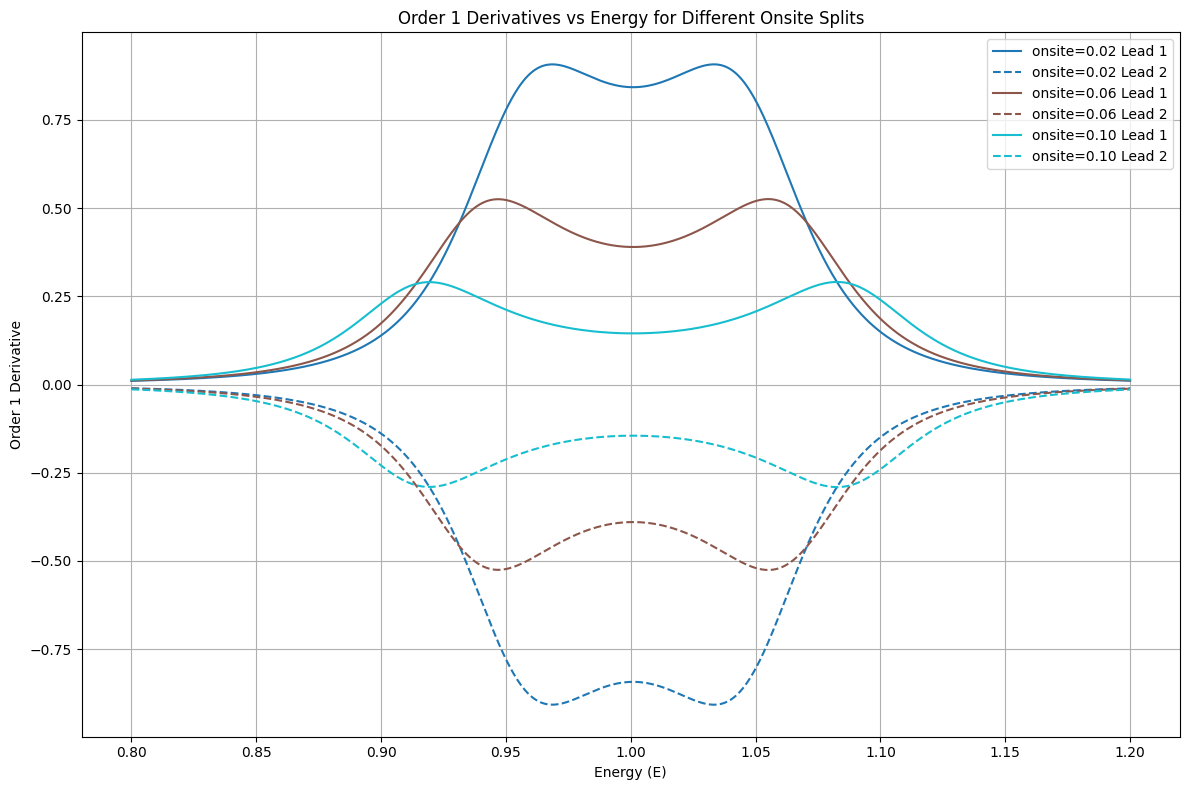

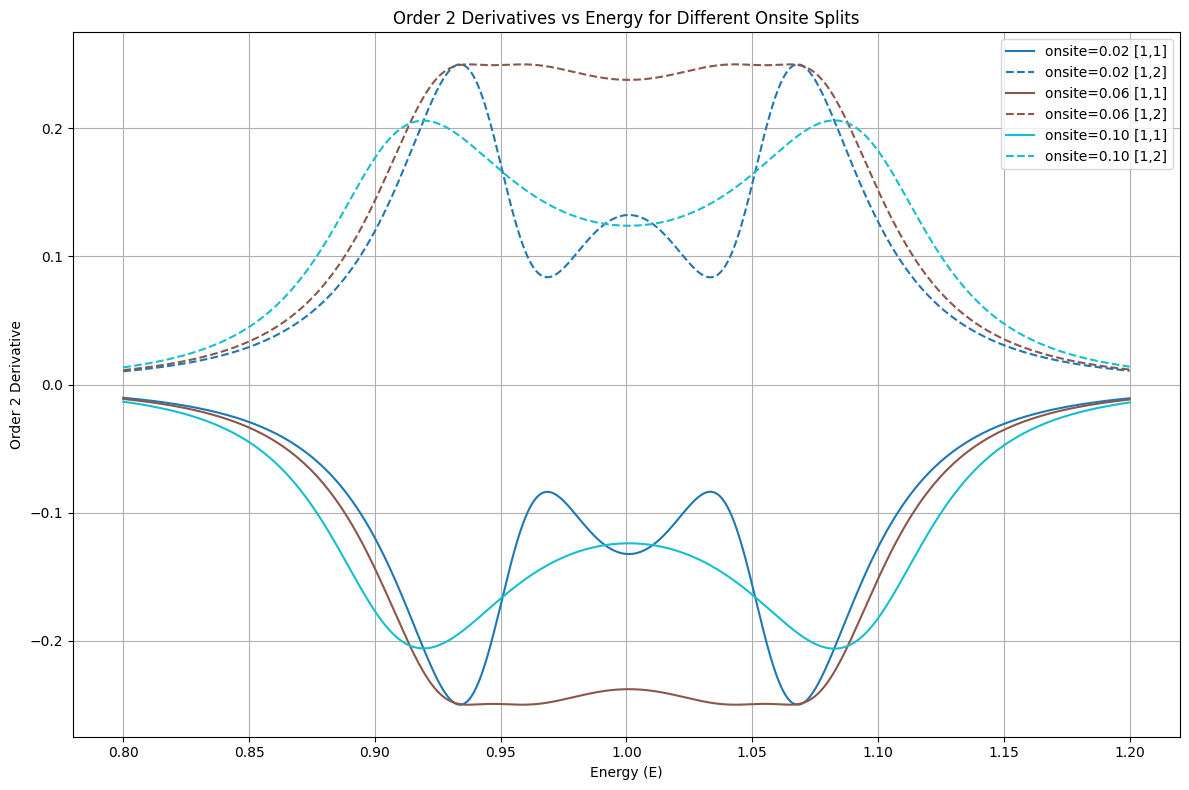

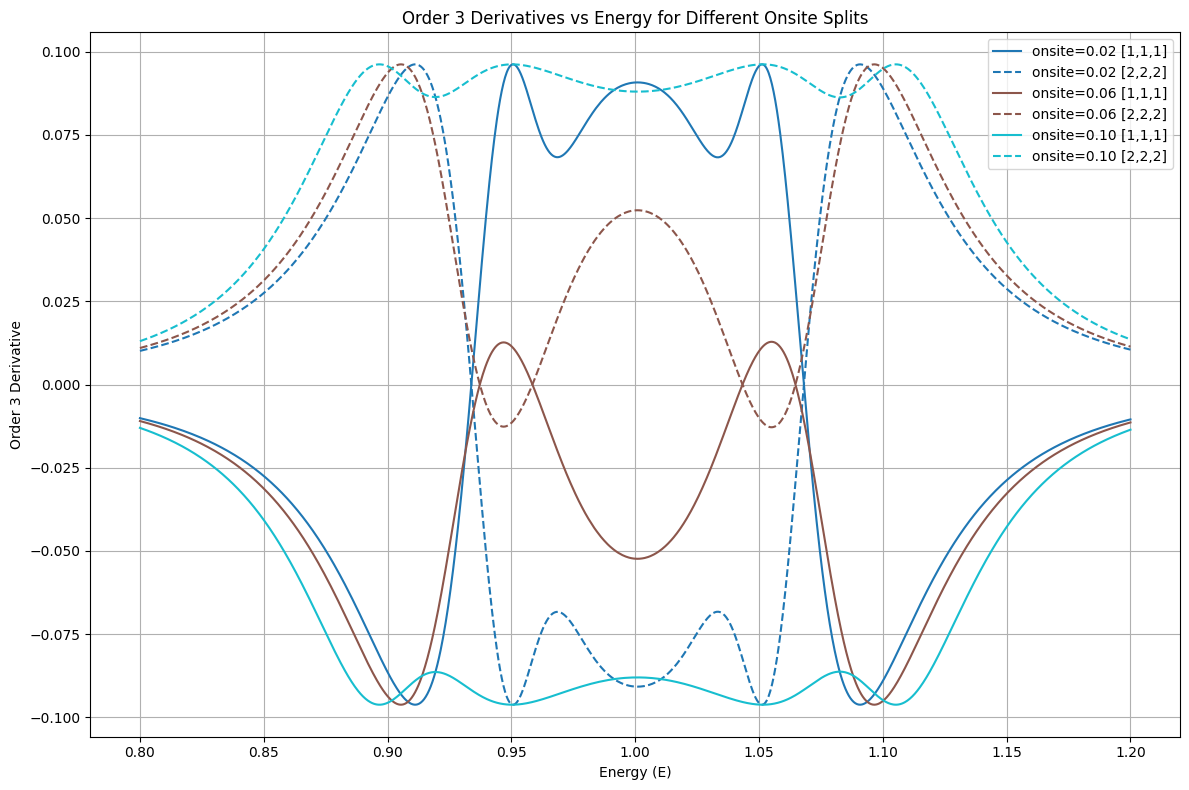

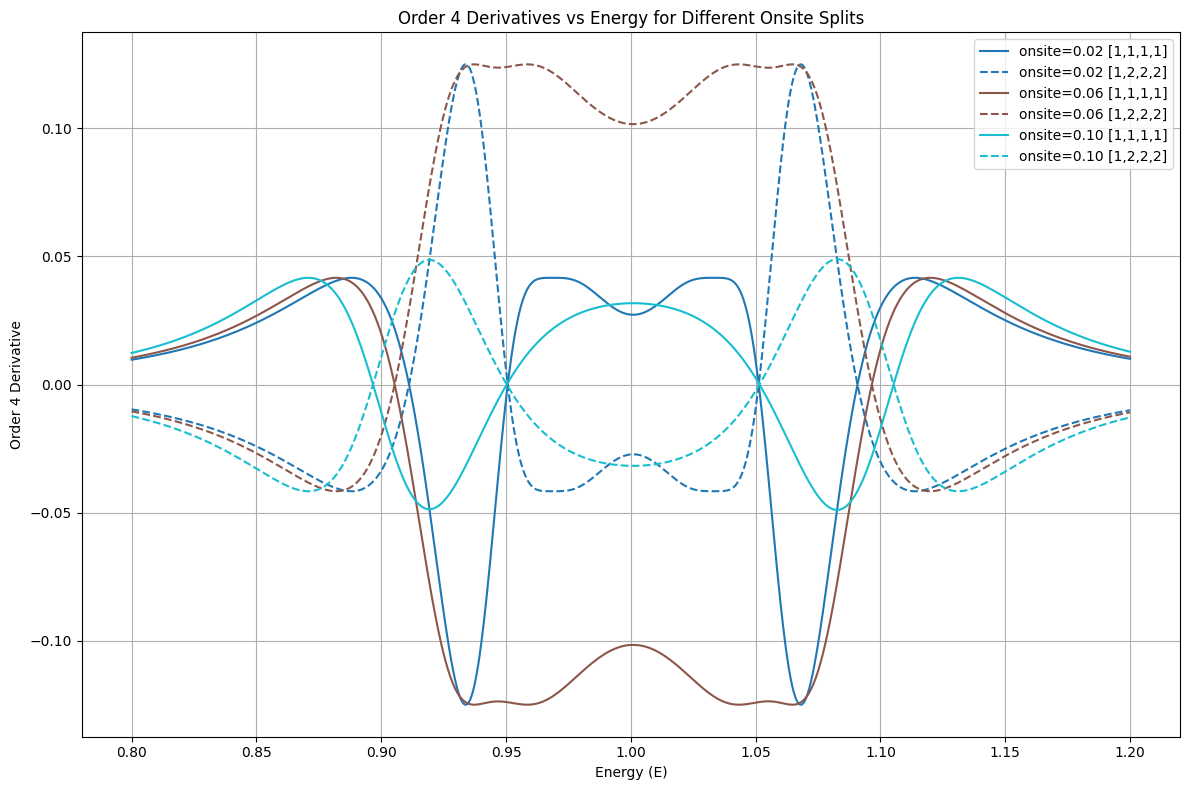

In [5]:

# Usage example:
# plot_comparison_from_files(plot_type="all")  # Generate all plots
# plot_comparison_from_files(plot_type="genfunc")  # Only generating function
plot_comparison_from_files_vary_onsite_split(plot_type="derivatives")  # Only derivatives